### 0. Library Import

In [1]:
## installation
! pip install efficientnet

In [2]:
#101
import os
import sys
import pandas as pd
import numpy as np
from skimage.io import imread

#plot
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

#files
from keras.preprocessing import image
import zipfile
from sklearn.model_selection import train_test_split

#macine learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

#model evaluation
from sklearn.metrics import precision_recall_curve, auc, f1_score,accuracy_score, precision_score, recall_score
from keras.callbacks import Callback

##pre-trained model
#efficientNet
from efficientnet.tfkeras import EfficientNetB0
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input

Using TensorFlow backend.


In [3]:
tf.__version__

'2.2.0'

### 1. Data Import

In [4]:
# check data availability
PATH="../input/iwildcam-2019-fgvc6/"
os.listdir(PATH)

['test_images.zip',
 'train.csv',
 'train_images.zip',
 'test.csv',
 'sample_submission.csv']

In [5]:
# class
classes_wild = {0: 'empty', 1: 'deer', 2: 'moose', 3: 'squirrel', 4: 'rodent', 5: 'small_mammal', \
                6: 'elk', 7: 'pronghorn_antelope', 8: 'rabbit', 9: 'bighorn_sheep', 10: 'fox', 11: 'coyote', \
                12: 'black_bear', 13: 'raccoon', 14: 'skunk', 15: 'wolf', 16: 'bobcat', 17: 'cat',\
                18: 'dog', 19: 'opossum', 20: 'bison', 21: 'mountain_goat', 22: 'mountain_lion'}

In [7]:
path_to_zip = "../input/iwildcam-2019-fgvc6/train_images.zip"
directory_to_extract="../output/kaggle/working/train_images"

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract)

zip_ref.close()

In [8]:
train_image_files = list(os.listdir(os.path.join(directory_to_extract)))
print("Number of image files: train:{}".format(len(train_image_files)))

Number of image files: train:196086


### 2. Data Wrangling

In [9]:
train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(PATH, 'test.csv'))

display(train_df.head())
display(test_df.head())

category_id        date_captured                                 file_name  \
0           19  2011-05-13 23:43:18  5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg   
1           19  2012-03-17 03:48:44  588a679f-23d2-11e8-a6a3-ec086b02610b.jpg   
2            0  2014-05-11 11:56:46  59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg   
3            0  2013-10-06 02:00:00  5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg   
4            0  2011-07-12 13:11:16  599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg   

   frame_num                                    id  location  rights_holder  \
0          1  5998cfa4-23d2-11e8-a6a3-ec086b02610b        33   Justin Brown   
1          2  588a679f-23d2-11e8-a6a3-ec086b02610b       115   Justin Brown   
2          1  59279ce3-23d2-11e8-a6a3-ec086b02610b        96  Erin Boydston   
3          1  5a2af4ab-23d2-11e8-a6a3-ec086b02610b        57  Erin Boydston   
4          3  599fbd89-23d2-11e8-a6a3-ec086b02610b        46   Justin Brown   

                                 seq_id  seq_num_frames  width  height  
0  6f084ccc-5567-11e8-bc84-dca9047ef277               3   1024     747  
1  6f12067d-5567-11e8-b3c0-dca9047ef277               3   1024     747  
2  6faa92d1-5567-11e8-b1ae-dca9047ef277               1   1024     747  
3  6f7d4702-5567-11e8-9e03-dca9047ef277               1   1024     747  
4  6f1728a1-5567-11e8-9be7-dca9047ef277               3   1024     747

date_captured                                 file_name  frame_num  \
0  03-Jan-2016 11:30:56  bce932f6-2bf6-11e9-bcad-06f10d5896c4.jpg          1   
1  03-Jan-2016 11:30:57  bce932f7-2bf6-11e9-bcad-06f10d5896c4.jpg          2   
2  03-Jan-2016 11:30:58  bce932f8-2bf6-11e9-bcad-06f10d5896c4.jpg          3   
3  03-Jan-2016 11:30:59  bce932f9-2bf6-11e9-bcad-06f10d5896c4.jpg          4   
4  03-Jan-2016 11:31:00  bce932fa-2bf6-11e9-bcad-06f10d5896c4.jpg          5   

                                     id  location  \
0  bce932f6-2bf6-11e9-bcad-06f10d5896c4        37   
1  bce932f7-2bf6-11e9-bcad-06f10d5896c4        37   
2  bce932f8-2bf6-11e9-bcad-06f10d5896c4        37   
3  bce932f9-2bf6-11e9-bcad-06f10d5896c4        37   
4  bce932fa-2bf6-11e9-bcad-06f10d5896c4        37   

                       rights_holder                                seq_id  \
0  Idaho Department of Fish and Game  6e9ac61c-2e32-11e9-90ef-dca9047ef277   
1  Idaho Department of Fish and Game  6e9ac61c-2e32-11e9-90ef-dca9047ef277   
2  Idaho Department of Fish and Game  6e9ac61c-2e32-11e9-90ef-dca9047ef277   
3  Idaho Department of Fish and Game  6e9ac61c-2e32-11e9-90ef-dca9047ef277   
4  Idaho Department of Fish and Game  6e9ac61c-2e32-11e9-90ef-dca9047ef277   

   seq_num_frames  width  height  
0               5   1024     726  
1               5   1024     726  
2               5   1024     726  
3               5   1024     726  
4               5   1024     726

In [10]:
display(train_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196299 entries, 0 to 196298
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   category_id     196299 non-null  int64 
 1   date_captured   196299 non-null  object
 2   file_name       196299 non-null  object
 3   frame_num       196299 non-null  int64 
 4   id              196299 non-null  object
 5   location        196299 non-null  int64 
 6   rights_holder   196299 non-null  object
 7   seq_id          196299 non-null  object
 8   seq_num_frames  196299 non-null  int64 
 9   width           196299 non-null  int64 
 10  height          196299 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 16.5+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153730 entries, 0 to 153729
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   date_captured   153730 non-null  object
 1   file_name       153730 non-null  object
 2   frame_num       153730 non-null  int64 
 3   id              153730 non-null  object
 4   location        153730 non-null  int64 
 5   rights_holder   153730 non-null  object
 6   seq_id          153730 non-null  object
 7   seq_num_frames  153730 non-null  int64 
 8   width           153730 non-null  int64 
 9   height          153730 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 11.7+ MB


None

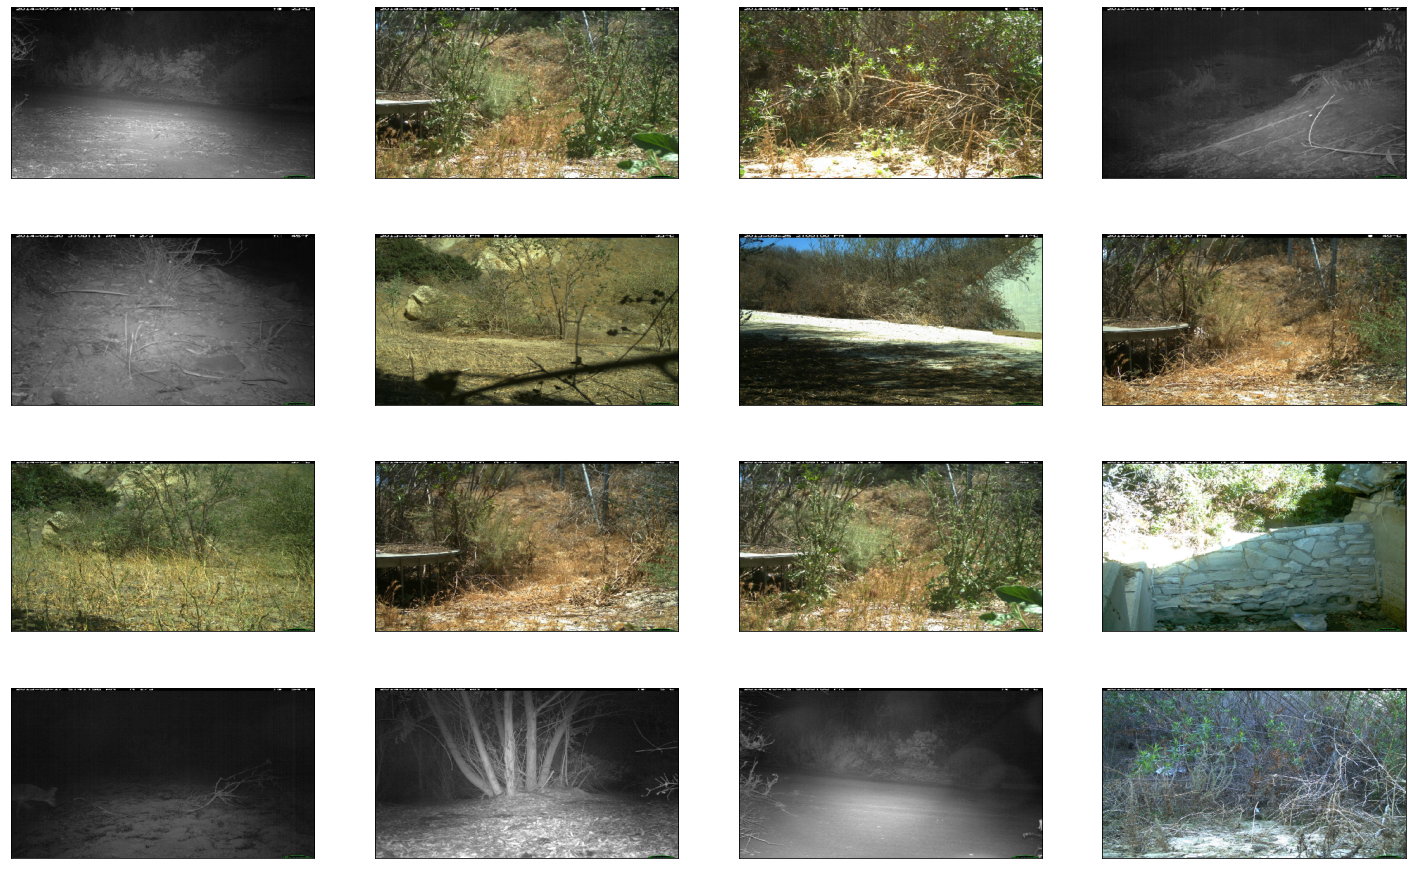

In [11]:
fig = plt.figure(figsize=(25, 16))
for i,im_path in enumerate(train_image_files[:16]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(os.path.join(directory_to_extract,im_path))
    im = im.resize((480,270))
    plt.imshow(im)

### 3. Feature Engineering

In [12]:
train_df.head()

category_id        date_captured                                 file_name  \
0           19  2011-05-13 23:43:18  5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg   
1           19  2012-03-17 03:48:44  588a679f-23d2-11e8-a6a3-ec086b02610b.jpg   
2            0  2014-05-11 11:56:46  59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg   
3            0  2013-10-06 02:00:00  5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg   
4            0  2011-07-12 13:11:16  599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg   

   frame_num                                    id  location  rights_holder  \
0          1  5998cfa4-23d2-11e8-a6a3-ec086b02610b        33   Justin Brown   
1          2  588a679f-23d2-11e8-a6a3-ec086b02610b       115   Justin Brown   
2          1  59279ce3-23d2-11e8-a6a3-ec086b02610b        96  Erin Boydston   
3          1  5a2af4ab-23d2-11e8-a6a3-ec086b02610b        57  Erin Boydston   
4          3  599fbd89-23d2-11e8-a6a3-ec086b02610b        46   Justin Brown   

                                 seq_id  seq_num_frames  width  height  
0  6f084ccc-5567-11e8-bc84-dca9047ef277               3   1024     747  
1  6f12067d-5567-11e8-b3c0-dca9047ef277               3   1024     747  
2  6faa92d1-5567-11e8-b1ae-dca9047ef277               1   1024     747  
3  6f7d4702-5567-11e8-9e03-dca9047ef277               1   1024     747  
4  6f1728a1-5567-11e8-9be7-dca9047ef277               3   1024     747

In [13]:
train_df['classes_wild'] = train_df['category_id'].apply(lambda cw: classes_wild[cw])

In [14]:
train_df.head()

category_id        date_captured                                 file_name  \
0           19  2011-05-13 23:43:18  5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg   
1           19  2012-03-17 03:48:44  588a679f-23d2-11e8-a6a3-ec086b02610b.jpg   
2            0  2014-05-11 11:56:46  59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg   
3            0  2013-10-06 02:00:00  5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg   
4            0  2011-07-12 13:11:16  599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg   

   frame_num                                    id  location  rights_holder  \
0          1  5998cfa4-23d2-11e8-a6a3-ec086b02610b        33   Justin Brown   
1          2  588a679f-23d2-11e8-a6a3-ec086b02610b       115   Justin Brown   
2          1  59279ce3-23d2-11e8-a6a3-ec086b02610b        96  Erin Boydston   
3          1  5a2af4ab-23d2-11e8-a6a3-ec086b02610b        57  Erin Boydston   
4          3  599fbd89-23d2-11e8-a6a3-ec086b02610b        46   Justin Brown   

                                 seq_id  seq_num_frames  width  height  \
0  6f084ccc-5567-11e8-bc84-dca9047ef277               3   1024     747   
1  6f12067d-5567-11e8-b3c0-dca9047ef277               3   1024     747   
2  6faa92d1-5567-11e8-b1ae-dca9047ef277               1   1024     747   
3  6f7d4702-5567-11e8-9e03-dca9047ef277               1   1024     747   
4  6f1728a1-5567-11e8-9be7-dca9047ef277               3   1024     747   

  classes_wild  
0      opossum  
1      opossum  
2        empty  
3        empty  
4        empty

In [15]:
## dataset splitting
x_train, x_test = train_test_split(train_df, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((157039, 12), (39260, 12))

In [16]:
test_datagen = ImageDataGenerator(rescale = 1./255)

train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.25,
                                 #horizontal_flip = True,    
                                 #zoom_range = 0.3,
                                 #width_shift_range = 0.3,
                                 #height_shift_range=0.3
                                )

In [17]:
train_generator=train_datagen.flow_from_dataframe(
                    dataframe=x_train,
                    directory="../output/kaggle/working/train_images/",
                    x_col="file_name",
                    y_col="classes_wild",
                    subset="training",
                    batch_size=64,
                    seed=424,
                    shuffle=True,
                    class_mode="categorical",
                    target_size=(128, 128))

valid_generator=train_datagen.flow_from_dataframe(
                    dataframe=x_train,
                    directory="../output/kaggle/working/train_images/",
                    x_col="file_name",
                    y_col="classes_wild",
                    subset="validation",
                    batch_size=64,
                    seed=424,
                    shuffle=True,
                    class_mode="categorical",
                    target_size=(128, 128))

Found 117780 validated image filenames belonging to 14 classes.
Found 39259 validated image filenames belonging to 14 classes.


In [18]:
print(train_generator.class_indices)

{'bobcat': 0, 'cat': 1, 'coyote': 2, 'deer': 3, 'dog': 4, 'empty': 5, 'fox': 6, 'mountain_lion': 7, 'opossum': 8, 'rabbit': 9, 'raccoon': 10, 'rodent': 11, 'skunk': 12, 'squirrel': 13}


In [19]:
print(valid_generator.class_indices)

{'bobcat': 0, 'cat': 1, 'coyote': 2, 'deer': 3, 'dog': 4, 'empty': 5, 'fox': 6, 'mountain_lion': 7, 'opossum': 8, 'rabbit': 9, 'raccoon': 10, 'rodent': 11, 'skunk': 12, 'squirrel': 13}


### 4. Modeling

In [20]:
num_classes = train_df['classes_wild'].nunique()

##### 4.1. EfficientNet

In [21]:
pre_trained_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(128,128,3))

for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 64, 64, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 64, 64, 32)   0           stem_bn[0][0]                    
___________________

In [22]:
# tuning on pre-trained model
effnet_model = tf.keras.models.Sequential()
effnet_model.add(pre_trained_model)
effnet_model.add(tf.keras.layers.GlobalAveragePooling2D())    
effnet_model.add(tf.keras.layers.Dense(num_classes, activation="softmax") )
effnet_model.summary()

opt = tf.keras.optimizers.Adam(lr=0.005, decay=1e-6)
effnet_model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 14)                17934     
Total params: 4,067,498
Trainable params: 17,934
Non-trainable params: 4,049,564
_________________________________________________________________


In [23]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')


In [24]:
history = effnet_model.fit(
            train_generator,
            validation_data = valid_generator,
            steps_per_epoch = 100,
            epochs = 20,
            batch_size=64,
            validation_steps = 50,
            callbacks = [early]
)

Epoch 1/20
100/100 [==============================] - 326s 3s/step - loss: 0.9200 - accuracy: 0.7240 - val_loss: 0.7281 - val_accuracy: 0.7753
Epoch 2/20
100/100 [==============================] - 323s 3s/step - loss: 0.6820 - accuracy: 0.7880 - val_loss: 0.6294 - val_accuracy: 0.8109
Epoch 3/20
100/100 [==============================] - 310s 3s/step - loss: 0.6394 - accuracy: 0.8025 - val_loss: 0.6429 - val_accuracy: 0.8012
Epoch 4/20
100/100 [==============================] - 310s 3s/step - loss: 0.6166 - accuracy: 0.8083 - val_loss: 0.6295 - val_accuracy: 0.8028
Epoch 5/20
100/100 [==============================] - 310s 3s/step - loss: 0.6121 - accuracy: 0.8041 - val_loss: 0.5879 - val_accuracy: 0.8219
Epoch 6/20
100/100 [==============================] - 308s 3s/step - loss: 0.6078 - accuracy: 0.8034 - val_loss: 0.5761 - val_accuracy: 0.8131
Epoch 7/20
100/100 [==============================] - 307s 3s/step - loss: 0.6067 - accuracy: 0.8052 - val_loss: 0.5648 - val_accuracy: 0.8222

In [25]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

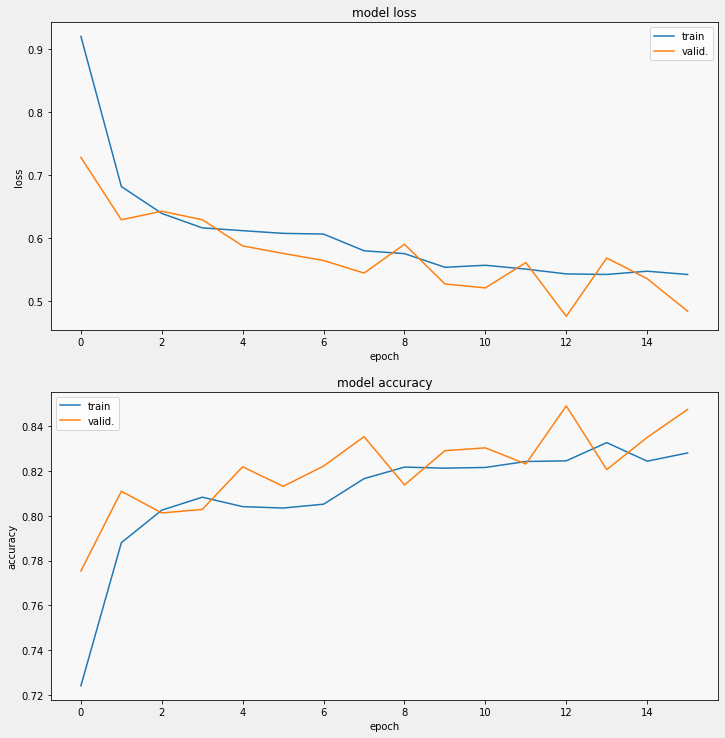

In [26]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

### Testing Dataset

In [27]:
test_generator = test_datagen.flow_from_dataframe(
                    dataframe=x_test,
                    directory="../output/kaggle/working/train_images/",
                    x_col="file_name",
                    y_col="classes_wild",
                    batch_size=64,
                    seed=424,
                    shuffle=True,
                    class_mode="categorical",
                    target_size=(128,128))

test_loss, test_acc =effnet_model.evaluate_generator(test_generator, steps=32)
print('test_loss_effnet: {} and test_acc_effnet: {} '.format(test_loss, test_acc))

Found 39260 validated image filenames belonging to 14 classes.
test_loss_effnet: 0.5204946994781494 and test_acc_effnet: 0.8310546875 


In [28]:
# # effnet
converter = tf.lite.TFLiteConverter.from_keras_model(effnet_model)
converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
effnet_tflite_model = converter.convert()


model_name = "effnet_tflite_model_b0"
open(f"{model_name}.tflite" , "wb").write(effnet_tflite_model)

4221600

### Unfreeze Layers Block7

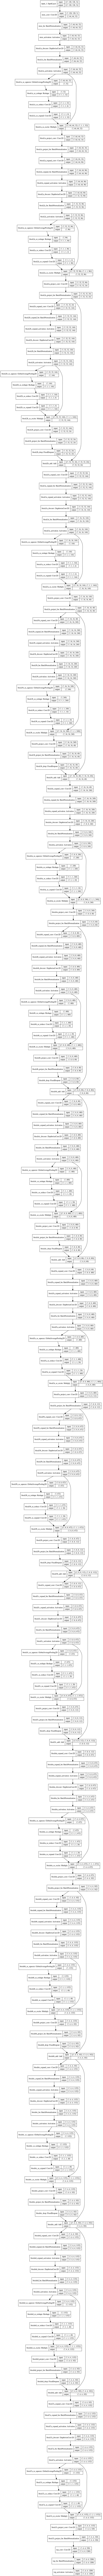

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_model, to_file='pretrained_model.png', show_shapes=True)
from IPython.display import Image
Image(filename='pretrained_model.png') 

In [40]:
for layer in pre_trained_model.layers:
    print(layer.name)

input_1
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand
block3a_se_excite
block3a_project_conv
block3a_project_bn
block3b_expand_conv
block3b_expan

In [41]:
pre_trained_model.trainable = True

set_trainable = False
for layer in pre_trained_model.layers:
    if layer.name == 'block7a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [42]:
effnet_model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

history = effnet_model.fit(
            train_generator,
            validation_data = valid_generator,
            steps_per_epoch = 100,
            epochs = 20,
            batch_size=64,
            validation_steps = 50,
            callbacks = [early]
)

Epoch 1/20
100/100 [==============================] - 310s 3s/step - loss: 1.2226 - accuracy: 0.7239 - val_loss: 8.9872 - val_accuracy: 0.5612
Epoch 2/20
100/100 [==============================] - 309s 3s/step - loss: 0.7480 - accuracy: 0.7753 - val_loss: 0.7271 - val_accuracy: 0.7828
Epoch 3/20
100/100 [==============================] - 308s 3s/step - loss: 0.6640 - accuracy: 0.7933 - val_loss: 0.6520 - val_accuracy: 0.8047
Epoch 4/20
100/100 [==============================] - 308s 3s/step - loss: 0.6287 - accuracy: 0.8020 - val_loss: 0.6080 - val_accuracy: 0.8053
Epoch 5/20
100/100 [==============================] - 308s 3s/step - loss: 0.5809 - accuracy: 0.8095 - val_loss: 0.6045 - val_accuracy: 0.7887
Epoch 6/20
100/100 [==============================] - 307s 3s/step - loss: 0.5431 - accuracy: 0.8322 - val_loss: 0.5248 - val_accuracy: 0.8363
Epoch 7/20
100/100 [==============================] - 307s 3s/step - loss: 0.5543 - accuracy: 0.8219 - val_loss: 0.5321 - val_accuracy: 0.8263

In [43]:
effnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 14)                17934     
Total params: 4,067,498
Trainable params: 1,147,326
Non-trainable params: 2,920,172
_________________________________________________________________


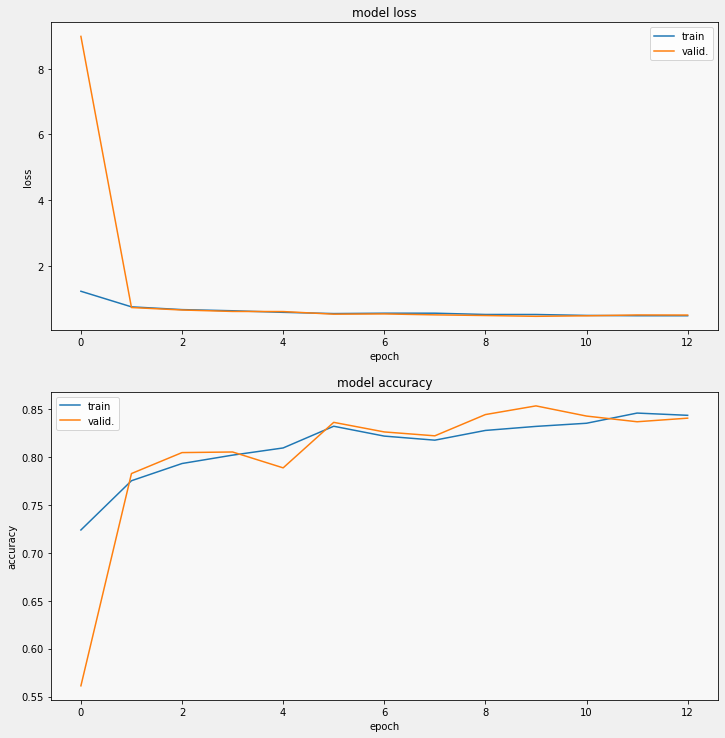

In [44]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [45]:
test_loss, test_acc =effnet_model.evaluate_generator(test_generator, steps=32)
print('test_loss_effnet: {} and test_acc_effnet: {} '.format(test_loss, test_acc))

test_loss_effnet: 0.5328012108802795 and test_acc_effnet: 0.83544921875 


In [53]:
# # effnet
converter = tf.lite.TFLiteConverter.from_keras_model(effnet_model)
converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
effnet_tflite_model = converter.convert()


model_name = "effnet_tflite_model_b0"
open(f"{model_name}.tflite" , "wb").write(effnet_tflite_model)

4221600

### Unfreeze: block6c_add

In [47]:
pre_trained_model.trainable = True

set_trainable = False
for layer in pre_trained_model.layers:
    if layer.name == 'block6c_add':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [48]:
effnet_model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

history = effnet_model.fit(
            train_generator,
            validation_data = valid_generator,
            steps_per_epoch = 100,
            epochs = 20,
            batch_size=64,
            validation_steps = 50,
            callbacks = [early]
)

Epoch 1/20
100/100 [==============================] - 311s 3s/step - loss: 0.5702 - accuracy: 0.8191 - val_loss: 0.5846 - val_accuracy: 0.8369
Epoch 2/20
100/100 [==============================] - 309s 3s/step - loss: 0.4863 - accuracy: 0.8442 - val_loss: 0.4820 - val_accuracy: 0.8369
Epoch 3/20
100/100 [==============================] - 309s 3s/step - loss: 0.4860 - accuracy: 0.8436 - val_loss: 0.4185 - val_accuracy: 0.8694
Epoch 4/20
100/100 [==============================] - 307s 3s/step - loss: 0.4511 - accuracy: 0.8567 - val_loss: 0.4374 - val_accuracy: 0.8656
Epoch 5/20
100/100 [==============================] - 309s 3s/step - loss: 0.4494 - accuracy: 0.8503 - val_loss: 0.4369 - val_accuracy: 0.8594
Epoch 6/20
100/100 [==============================] - 308s 3s/step - loss: 0.4228 - accuracy: 0.8608 - val_loss: 0.4377 - val_accuracy: 0.8516
Epoch 00006: early stopping


In [49]:
effnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 14)                17934     
Total params: 4,067,498
Trainable params: 1,735,278
Non-trainable params: 2,332,220
_________________________________________________________________


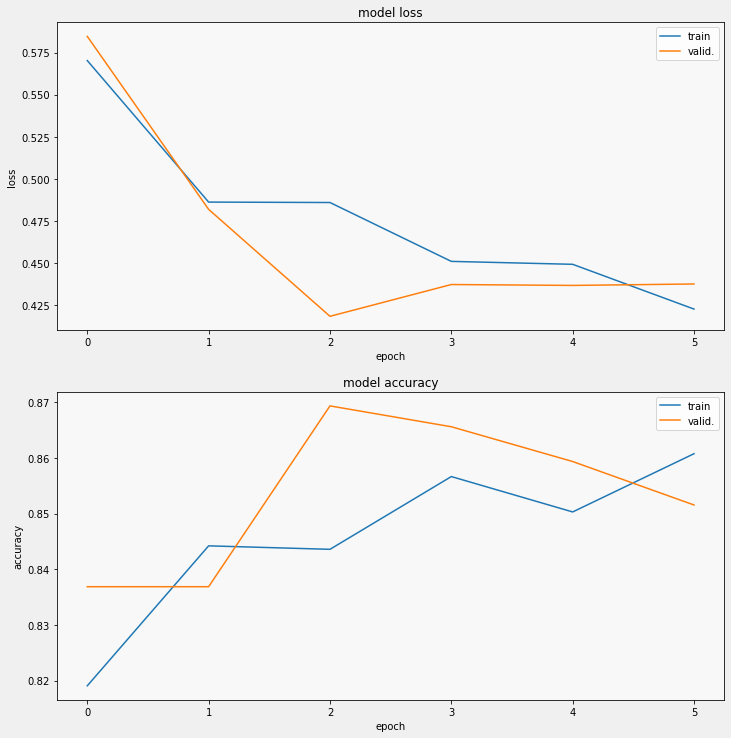

In [50]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [51]:
test_loss, test_acc =effnet_model.evaluate_generator(test_generator, steps=32)
print('test_loss_effnet: {} and test_acc_effnet: {} '.format(test_loss, test_acc))

test_loss_effnet: 0.4640350639820099 and test_acc_effnet: 0.84326171875 


In [52]:
# # effnet
converter = tf.lite.TFLiteConverter.from_keras_model(effnet_model)
converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
effnet_tflite_model = converter.convert()


model_name = "effnet_tflite_model_b2"
open(f"{model_name}.tflite" , "wb").write(effnet_tflite_model)

4221600

### Unfreeze: block6a_expand_conv

In [54]:
pre_trained_model.trainable = True

set_trainable = False
for layer in pre_trained_model.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [55]:
effnet_model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

history = effnet_model.fit(
            train_generator,
            validation_data = valid_generator,
            steps_per_epoch = 100,
            epochs = 20,
            batch_size=64,
            validation_steps = 50,
            callbacks = [early]
)

Epoch 1/20
100/100 [==============================] - 314s 3s/step - loss: 0.7945 - accuracy: 0.7597 - val_loss: 13.8504 - val_accuracy: 0.3950
Epoch 2/20
100/100 [==============================] - 315s 3s/step - loss: 0.5652 - accuracy: 0.8156 - val_loss: 0.6883 - val_accuracy: 0.8147
Epoch 3/20
100/100 [==============================] - 311s 3s/step - loss: 0.5505 - accuracy: 0.8225 - val_loss: 0.5937 - val_accuracy: 0.8053
Epoch 4/20
100/100 [==============================] - 310s 3s/step - loss: 0.5220 - accuracy: 0.8267 - val_loss: 0.5105 - val_accuracy: 0.8400
Epoch 5/20
100/100 [==============================] - 310s 3s/step - loss: 0.4894 - accuracy: 0.8406 - val_loss: 0.4532 - val_accuracy: 0.8525
Epoch 6/20
100/100 [==============================] - 309s 3s/step - loss: 0.4762 - accuracy: 0.8414 - val_loss: 0.4659 - val_accuracy: 0.8509
Epoch 7/20
100/100 [==============================] - 309s 3s/step - loss: 0.4288 - accuracy: 0.8567 - val_loss: 0.4525 - val_accuracy: 0.852

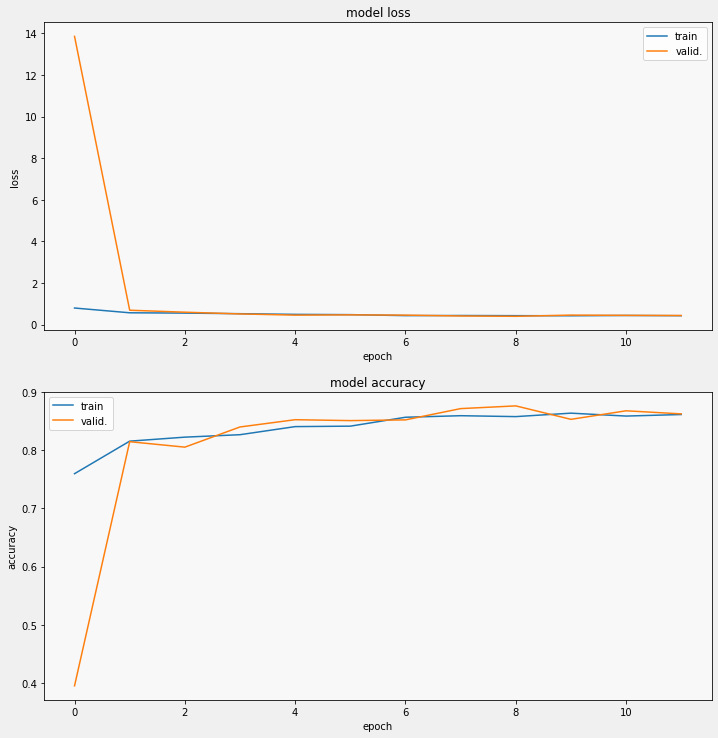

In [56]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [61]:
effnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 14)                17934     
Total params: 4,067,498
Trainable params: 3,173,674
Non-trainable params: 893,824
_________________________________________________________________


In [57]:
test_loss, test_acc =effnet_model.evaluate_generator(test_generator, steps=32)
print('test_loss_effnet: {} and test_acc_effnet: {} '.format(test_loss, test_acc))

test_loss_effnet: 0.4516219198703766 and test_acc_effnet: 0.85400390625 


In [58]:
# # effnet
converter = tf.lite.TFLiteConverter.from_keras_model(effnet_model)
converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
effnet_tflite_model = converter.convert()


model_name = "effnet_tflite_model_b3"
open(f"{model_name}.tflite" , "wb").write(effnet_tflite_model)

4221600

In [60]:
#effnet_TL_6c is equal to effnet_tflite_model_b3
effnet_model.save('effnet_TL_6c')